In [2]:
%matplotlib ipympl
# for development
%load_ext autoreload
%aimport rite_vs2
%aimport rite_vs2.decoder
%aimport rite_vs2.utils
%autoreload 1

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors

import rite_vs2
import rite_vs2.decoder as rdc
import rite_vs2.utils as rutils

In [4]:
# chunk/packets processors
metada_proc = rdc.metadada_processor()
data_proc = rdc.datastream_processor()

# chnk import function
read_chunk = rdc.read_chunk_v1

# DK storage ports
port_META = rite_vs2.DK_PORT_META
port_DATA = rite_vs2.DK_PORT_DATA

In [5]:
# METADATA chunk

#det_id = 'C07-W0337'   # flight CdTe detector (v2)
#det_id = 'J08-W0281'   # test-Si detector (v2)
det_id = 'E04-W0332'   # test-zlaty detector (v1)

#name = "/home/vzlusta2/zdenek/rite-simul/dk-chunks-Si-2020-09-06-d"
#name = "/home/vzlusta2/zdenek/rite-simul/vcom-dump/dk-x"
#name = "/home/vzlusta2/recon/dk-y"
#name = "/home/vzlusta2/zdenek/rite-simul/vcom-dump/chunks-2020-09-09"
#name = "dk-chunks-24"
#name = "/tmp/roi-1"
#name = "/Users/zdenek/tmp/recon/chunks-2020-09-09"
#name = "/Users/zdenek/tmp/recon/rite_data/chunks-2022-04-19" # Americium package from Ada 
name = "/Users/zdenek/tmp/recon/rite_data/june22a" 

#meta_chunk_id = 37
meta_chunk_id = 1411

print("name: %s\nmeta_chunk_id = %d\n" % (name, meta_chunk_id,))

chunk_meta = read_chunk(name, port_META, meta_chunk_id)

if chunk_meta is not None:
    pck_info = metada_proc.process(chunk_meta)
    rdc.print_metadata(pck_info)

name: /Users/zdenek/tmp/recon/rite_data/june22a
meta_chunk_id = 1411

[RITE] start_nb: 1
[MEAS] exp_nb: 460
[MEAS] frame_id: 0x01cc
[MEAS] time: 2022-06-17 06:45:01.621 UTC
[DATA] outputForm: 18
[DATA] firstChunkId: 97378
[DATA] lastChunkId: 97446
[DET] mode: 1
[DET] scan mode, (count) threshold, roi: 1, 500, 0
[DET] frameTime: 0.1 (sec)
[DET] bias: 200 (V)
[DET] threshold: 5.01634 (keV)
[DET] nFrames: 100
[PROC] filtering: 6
[PROC] (frame) min, max, (filtered) min, max:          5      65502          5       7824
[PROC]    id  row  col  hgt  wdh  frame-evt   filt-evt  frame-sum   filt-sum
[PROC] roi0:    0    0  256  256        646         38   14479040      14927
[PROC] roi1:    0    0  128  128          9          3        157        117
[PROC] roi2:    0  128  128  128        588         23   14476229      13074
[PROC] roi3:  128    0  128  128         14          5       1765       1479
[PROC] roi4:  128  128  128  128         35          7        889        257


In [6]:
# DATA chunks processing loop

data_proc.reset() # same processor can be reused for different measurements

for k in range(pck_info['first_chunk'], pck_info['last_chunk']+1):
    chunk_pck = read_chunk(name, port_DATA, k)
    
    if chunk_pck is None:
        print("ERROR: Could not read chunk_id=%d" % k)
        continue
    
    data_proc.process(chunk_pck)

# print some data overview    
data_proc.print_info()

# get result
data = data_proc.data

# show typical access to data items, note: some of them may be still lists of arrays
ehist = data['ehist']
bin8 = data['bin8']
bin16 = data['bin16']
bin32 = data['bin32']
filt = data['filt']
frame = data['frame']
col_proj = data['col_proj']
row_proj = data['row_proj']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zdenek/tmp/recon/rite_data/june22a/016-0003-097378'

In [7]:
# plot frame

if frame is not None:
    plt.figure()
    img = frame
    plt.subplot(111), plt.title('frame 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                              np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No frame data")

NameError: name 'frame' is not defined

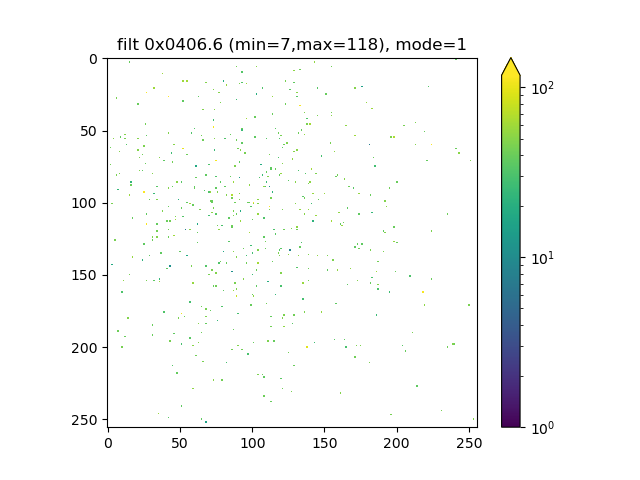

In [7]:
# plot filt

if filt is not None:
    plt.figure()
    img = filt
    plt.subplot(111), plt.title('filt 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                             np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No filt data")

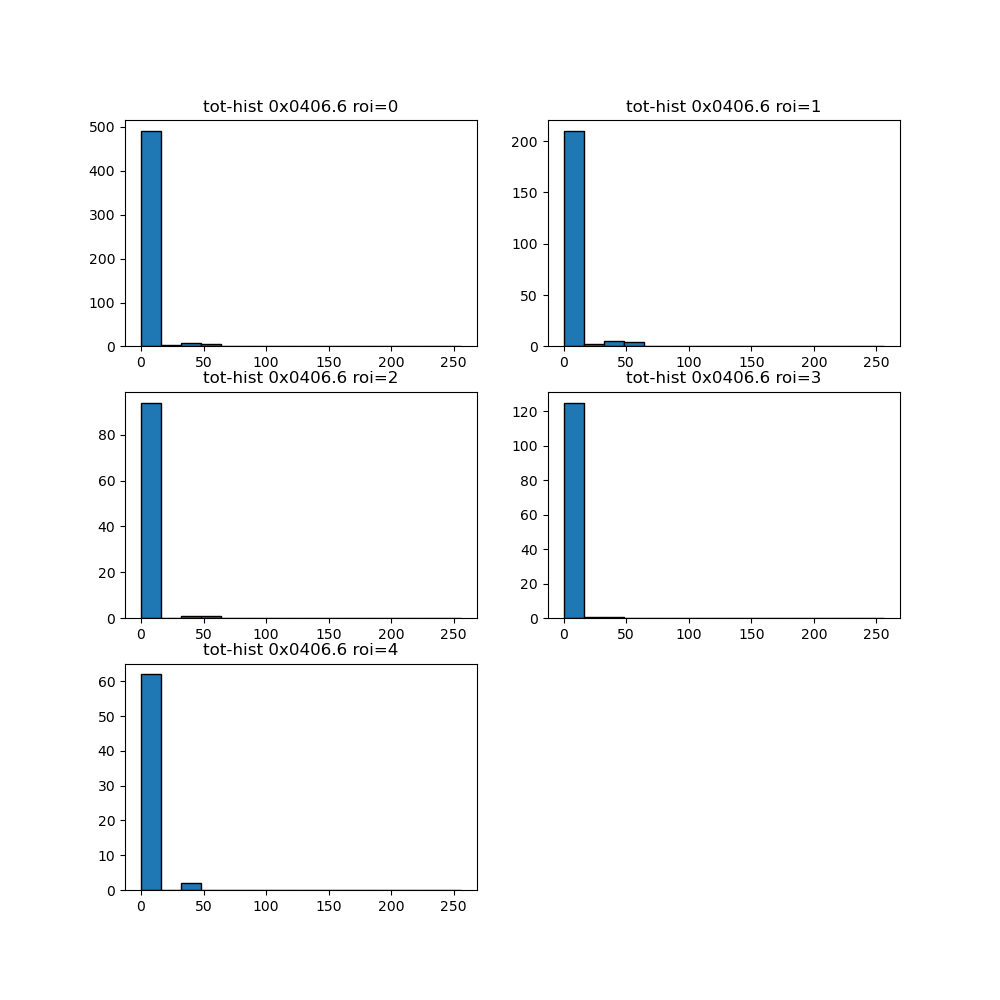

In [8]:
# plot ehist

plt.figure(figsize=(10, 10), dpi=100)

if ehist is not None:
    for iroi in range(rite_vs2.DET_NROIS):
        if ehist[iroi][0] is not None:
            plt.subplot(3,2,iroi+1), plt.title('tot-hist 0x%04x.%d roi=%d' % (pck_info['frame_id'], pck_info['exp_nb'], iroi,))
            edges = np.linspace(0,ehist[iroi][1],rite_vs2.DET_EHIST_NBINS+1)
            plt.bar(edges[:-1], ehist[iroi][0], width=np.diff(edges), edgecolor="black", align="edge")
else:
    print("No ehist data")

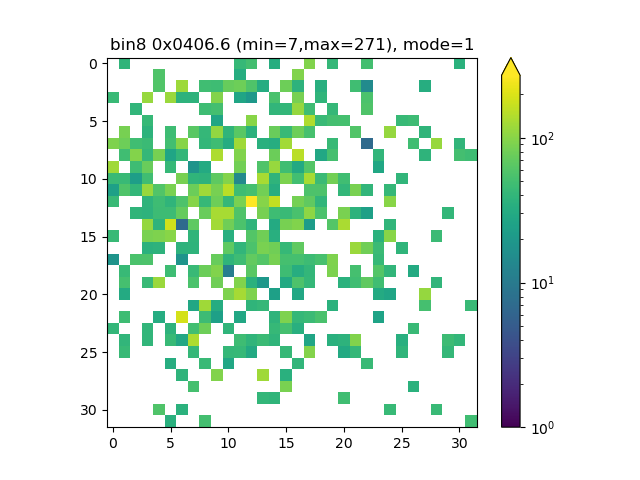

In [9]:
# plot bin8

if filt is not None:
    plt.figure()
    img = bin8
    plt.subplot(111), plt.title('bin8 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'],
                                                                             np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No bin8 data")

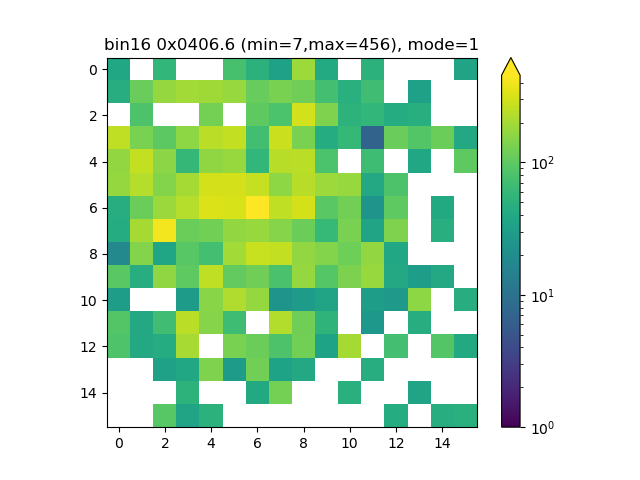

In [10]:
# plot bin16

if filt is not None:
    plt.figure()
    img = bin16
    plt.subplot(111), plt.title('bin16 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                              np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No bin16 data")

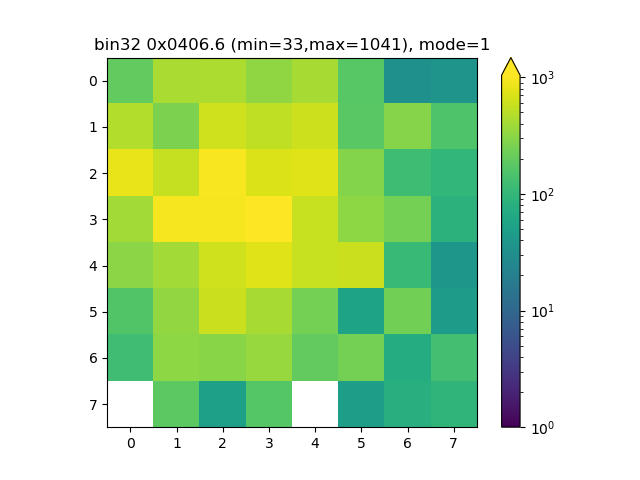

In [11]:
# plot bin32

if filt is not None:
    plt.figure()
    img = bin32
    plt.subplot(111), plt.title('bin32 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                              np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No bin32 data")

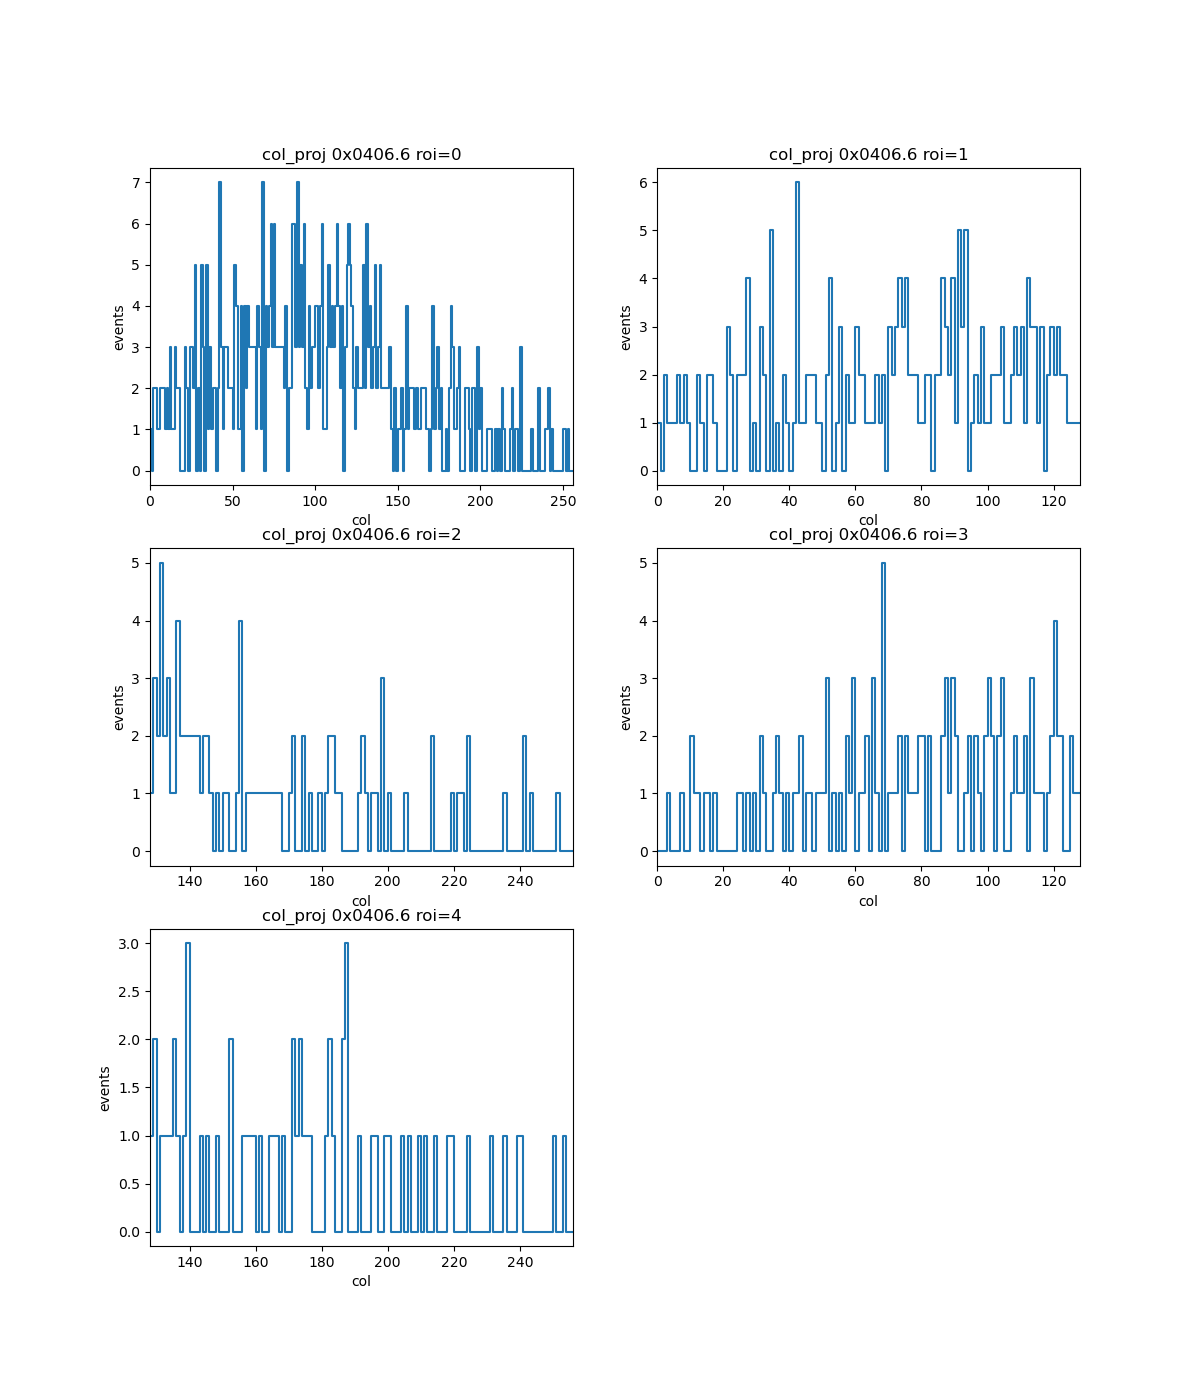

In [12]:
# plot col_proj

plt.figure(figsize=(12, 14), dpi=100)

if col_proj is not None:
    for iroi in range(rite_vs2.DET_NROIS):
        if col_proj[iroi] is not None:
            roi = pck_info['rois'][iroi]
            first = roi[1]
            last = roi[1]+roi[3]
            plt.subplot(3,2,iroi+1), plt.title('col_proj 0x%04x.%d roi=%d' % (pck_info['frame_id'], pck_info['exp_nb'], iroi,))
            x = np.linspace(first,last,last-first+1,endpoint=True)
            xx = np.zeros((2*(x.size-1),))
            xx[0::2] = x[:-1]
            xx[1::2] = x[1:]
            yy = np.zeros((2*(x.size-1),))
            yy[0::2] = col_proj[iroi]
            yy[1::2] = col_proj[iroi]
            plt.plot(xx, yy)
            plt.xlim((first,last))
            plt.xlabel('col')
            plt.ylabel('events')
else:
    print("No col_proj data")

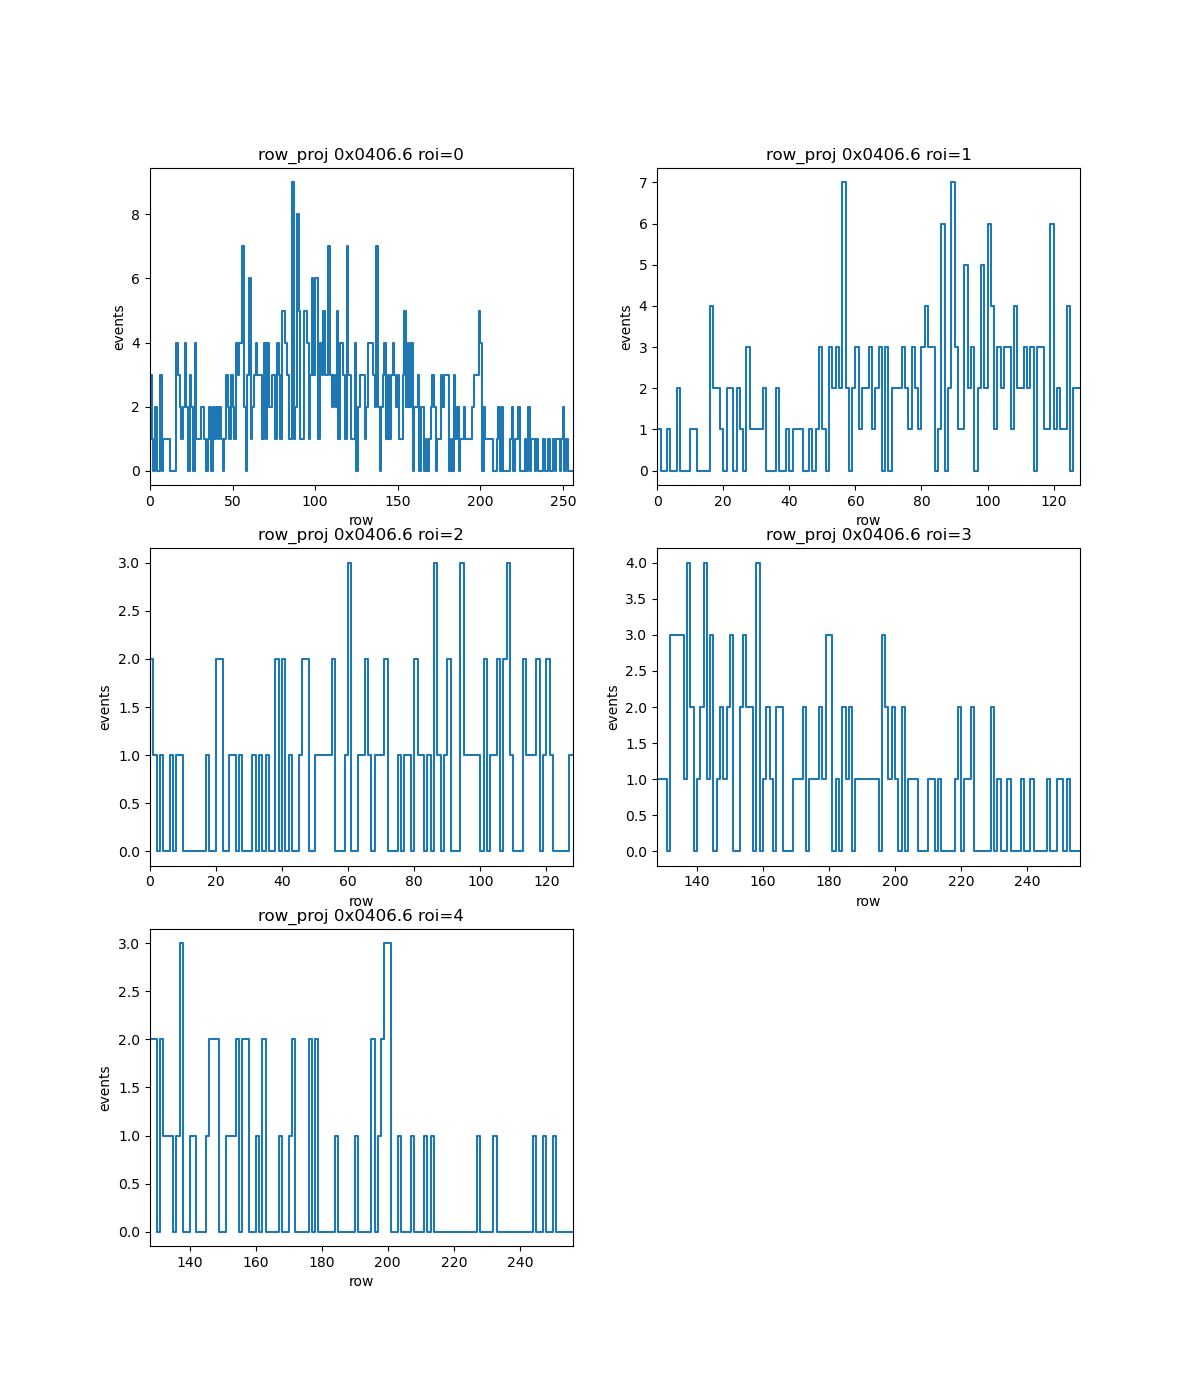

In [13]:
# plot row_proj

plt.figure(figsize=(12, 14), dpi=100)

if row_proj is not None:
    for iroi in range(rite_vs2.DET_NROIS):
        if row_proj[iroi] is not None:
            roi = pck_info['rois'][iroi]
            first = roi[0]
            last = roi[0]+roi[2]
            plt.subplot(3,2,iroi+1), plt.title('row_proj 0x%04x.%d roi=%d' % (pck_info['frame_id'], pck_info['exp_nb'], iroi,))
            x = np.linspace(first,last,last-first+1,endpoint=True)
            xx = np.zeros((2*(x.size-1),))
            xx[0::2] = x[:-1]
            xx[1::2] = x[1:]
            yy = np.zeros((2*(x.size-1),))
            yy[0::2] = row_proj[iroi]
            yy[1::2] = row_proj[iroi]
            plt.plot(xx, yy)
            plt.xlim((first,last))
            plt.xlabel('row')
            plt.ylabel('events')
else:
    print("No row_proj data")

In [14]:
data['ehist'][0][0] # in tot

array([491,   3,   9,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

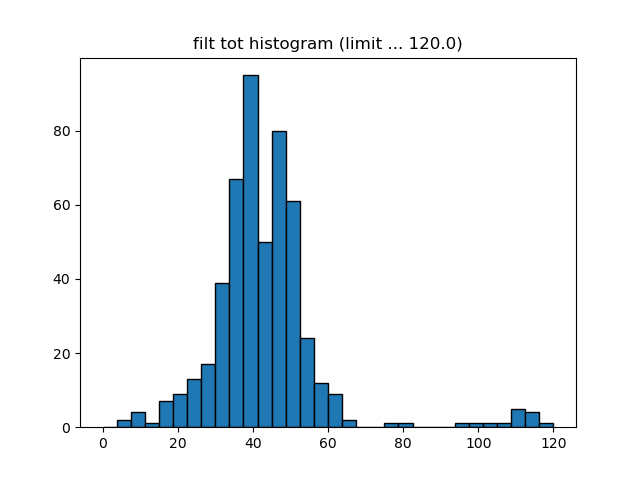

In [15]:
tot_max = 120.0

tot0calc, totedges = rutils.calc_histogram(data['filt'], en_max=tot_max, nbins=32)

plt.figure()
plt.subplot(111), plt.title('filt tot histogram (limit ... %.1f)' % (tot_max,))
plt.bar(totedges[:-1], tot0calc, width=np.diff(totedges), edgecolor="black", align="edge");

nan energy values: 0


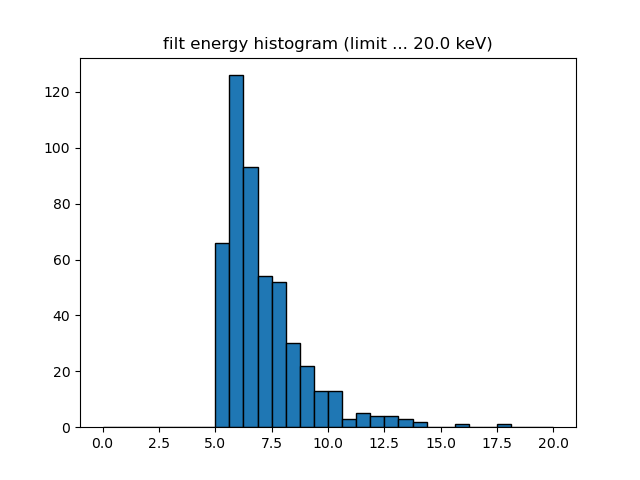

In [16]:
# convert to energies (using calibration)

en0 = rutils.tot2energy(data['filt'], det_id)
print("nan energy values: %d" % (np.count_nonzero(np.isnan(en0)),))
en0[np.isnan(en0)] = 0

en_max = 20.0

e0calc, edges = rutils.calc_histogram(en0, en_max=en_max, nbins=32)

plt.figure()
plt.subplot(111), plt.title('filt energy histogram (limit ... %.1f keV)' % (en_max,))
plt.bar(edges[:-1], e0calc, width=np.diff(edges), edgecolor="black", align="edge");

In [17]:
# test if energy histogram and raw data are connected via correct calibration
_en0 = rutils.tot2energy(data['filt'], det_id)
#_en0 = rutils.tot2energy(data['filt'], 'C07-W0337')
_e0calc, _edges = rutils.calc_histogram(_en0, en_max=256, nbins=16)

_e0calc - ehist[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
ehist[0][0]

array([491,   3,   9,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (32,) and arg 1 with shape (16,).

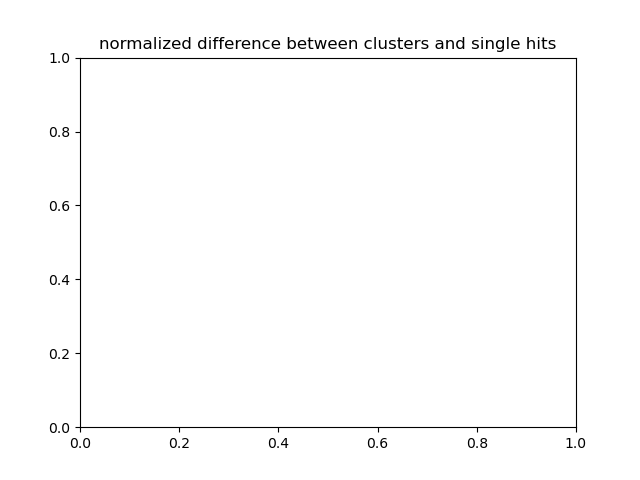

In [19]:
x1 = np.array([294,  82,  50,  30,  20,  12,   6,   2,   1,   2,   0,   0,   0, 0,   0,   0])/925
x2 = np.array([217,  81,  49,  46,  38,  20,  17,  19,   6,   3,   2,   0,   1, 0,   0,   0])/513

plt.figure()
plt.subplot(111), plt.title('normalized difference between clusters and single hits')
plt.bar(edges[:-1], x2-x1, width=np.diff(edges), edgecolor="black", align="edge");

In [1]:
import pytz
from datetime import datetime

In [4]:
prg = pytz.timezone('Europe/Prague')

In [10]:
loc_dt = prg.localize(datetime(2022, 2, 19, 1, 30, 00))
print(loc_dt)

2022-02-19 01:30:00+01:00


In [6]:
loc_dt

datetime.datetime(2020, 1, 1, 1, 0, tzinfo=<DstTzInfo 'Europe/Prague' CET+1:00:00 STD>)

In [34]:
def is_dst(dt):
    """Determine whether or not Daylight Savings Time (DST)
    is in effect for a given date and time"""

    x = datetime(dt.year, 1, 1, 1, 0, 0, 0, tzinfo=pytz.timezone(dt.tzinfo.zone)) # Jan 1 of the relevant year
    x_offset = ((x.utcoffset().seconds + 1800) // 3600) * 3600
    dt_offset = ((dt.utcoffset().seconds + 1800) // 3600) * 3600
    
    # if DST is in effect, their offsets will be different
    return not (x_offset == dt_offset)

In [38]:
loc_dt = prg.localize(datetime(2020, 4, 2, 1, 30, 0))
print('loct_dt:',loc_dt)
print(is_dst(loc_dt))

loct_dt: 2020-04-02 01:30:00+02:00
True


In [18]:
offset = loc_dt.utcoffset()

In [26]:
offset.seconds

3600